In [1]:
import inspect
import os

import numpy as np
import pandas as pd
from docopt import docopt
from csrank.fate_ranking import FATEObjectRanker
from csrank.objectranking.feta_ranker import FETANetwork
from csrank.callbacks import DebugOutput
from csrank.metrics import zero_one_rank_loss_for_scores
from csrank.util import rename_file_if_exist, configure_logging_numpy_keras, get_tensor_value
from csrank.dataset_reader import SyntheticDatasetGenerator
from keras.callbacks import History

Using TensorFlow backend.


Defining the Constants

In [2]:
MODEL = "aModel"
ERROR_OUTPUT_STRING = 'Out of sample error {} : {} for n_objects {}'
his = History()
his.__name__ = "History"
objects = "Objects"

Generate the Medoid sythentic dataset for defined number of objects

In [3]:
def generate_dataset(n_objects=5, random_state=42):
    parameters = {"n_features": 2, "n_objects": n_objects, 
                  "n_train_instances": 10000, "n_test_instances": 100000,
                  "dataset_type": "medoid",
                  "random_state":random_state}
    generator = SyntheticDatasetGenerator(**parameters)
    return generator.get_single_train_test_split()

Fit the given ranker and predict on rankings with different sizes and check the zero one rank loss for them

In [4]:
def get_evaluation_result(gor, X_train, Y_train, epochs):
    gor.fit(X_train, Y_train, log_callbacks=[DebugOutput(delta=10), his], verbose=False, epochs=epochs)
    eval_results = {}
    for n_objects in np.arange(3, 20):
        _, _, X_test, Y_test = generate_dataset(n_objects=n_objects, random_state=seed + n_objects * 5)
        y_pred_scores = gor.predict_scores(X_test, batch_size=X_test.shape[0])
        metric_loss = get_tensor_value(zero_one_rank_loss_for_scores(Y_test, y_pred_scores))
        logger.info(ERROR_OUTPUT_STRING.format("zero_one_rank_loss", str(np.mean(metric_loss)), n_objects))
        eval_results[n_objects] = metric_loss
    return eval_results

Initialize the log file path and the dataframe path.

In [5]:
n_objects = 5
dirname = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(dirname, "logs", "generalizing_mean_{}.log".format(n_objects))
df_path = os.path.join(dirname, "logs", "generalizing_mean_{}.csv".format(n_objects))
random_state = np.random.RandomState(seed=42)
seed = random_state.randint(2 ** 32)

Initialize tensorflow and keras with the seed and initialize the log file path

In [6]:
rows_list = []
logger = configure_logging_numpy_keras(seed=seed, log_path=log_path)

X_train, Y_train, _, _ = generate_dataset(n_objects=n_objects, random_state=seed)
n_instances, n_objects, n_features = X_train.shape

epochs = 700
params = {"n_objects": n_objects, 
          "n_features": n_features, 
          "n_object_features": n_features, 
          "use_early_stopping": True, 
          "metrics":[zero_one_rank_loss_for_scores]}

Evaluate the FETANetwork with best parameters and check the generalization

In [7]:
logger.info("############################# With Best Parameters FETA ##############################")
gor = FETANetwork(**params)
result = get_evaluation_result(gor, X_train, Y_train, epochs)
result[MODEL] = "FETARankerDefault"
rows_list.append(result)

Evaluate the FATEObjectRanker with best parameters and check the generalization

In [ ]:
from csrank.losses import smooth_rank_loss
logger.info("############################# With Best Parameters FATE ##############################")
gor = FATEObjectRanker(**params)
result = get_evaluation_result(gor, X_train, Y_train, epochs)
result[MODEL] = "FATERankerDefault"
rows_list.append(result)

Save the results into a dataframe

In [70]:
df = pd.DataFrame(rows_list)
df = df.set_index(MODEL).T
cols = list(df.columns.values)
df

aModel,FATERankerDefault
3,0.218561
4,0.947871
5,0.692061
6,0.669744
7,0.932732
8,0.804914
9,0.941135
10,0.964858
11,0.970023
12,0.090049


If the there is an eisting csv file saved then load it and add the new columns containing the results to it

In [18]:
if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame

,Objects,FETARankerBestParams,FETARanker,FATERanker,FATERanker10SetLayers,FATERanker8SetLayers
0,3,0.198587,0.194951,0.082433,0.065285,0.094951
1,4,0.226475,0.228402,0.141888,0.120779,0.125498
2,5,0.218070,0.224131,0.109125,0.103804,0.107595
3,6,0.215545,0.227914,0.133907,0.109337,0.107254
4,7,0.211587,0.228970,0.134549,0.110699,0.107393
5,8,0.207721,0.230498,0.142830,0.112166,0.107801
6,9,0.203656,0.230520,0.147908,0.113533,0.110187
7,10,0.200119,0.230697,0.153753,0.115446,0.112828
8,11,0.196479,0.230296,0.157704,0.116400,0.115010
9,12,0.193027,0.230299,0.161388,0.116445,0.116744


Save the dataframe to given file path

In [71]:
dataFrame.to_csv(df_path, index=objects)

Plot the results of the zero one rank accuracy

<IPython.core.display.Javascript object>


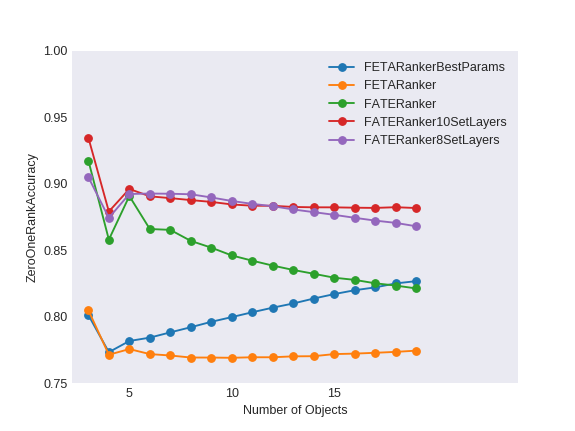

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns; 
sns.set(color_codes=True)
plt.style.use('default')
sns.set_style("dark")

y_label="ZeroOneRankAccuracy"
x_label="Number of Objects"
fig, ax = plt.subplots()
for col in dataFrame.columns.values[1:]:
    plt.plot(dataFrame[dataFrame.columns.values[0]], 1 - dataFrame[col], marker="o",label=col)
ax.xaxis.set_ticks(np.arange(3, 25))
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.xticks(np.arange(5, 20, 5))
plt.yticks(np.arange(0.75,1.01,0.05))
plt.legend(loc="best")
plot_path =os.path.join(os.getcwd(), "logs" ,"generalizing.png")
plt.savefig(plot_path, facecolor='w', edgecolor='w',transparent=False, dpi=800,format='png')
plt.show()